In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyBigWig
import pickle
from tqdm import tqdm

In [2]:
RANGE = range(5, 105, 5)
NUM_GENERATIONS = 500

In [3]:
# file_with_tads = "../data/input/tad_boundaries_hESC_IMR90_hg19/h1.rep1.bed"
# tad_boundaries = list(map(lambda x: x.split(), open(file_with_tads).readlines()))
# tad_boundaries = np.array(tad_boundaries)

fin = dict()
for i in RANGE:
    fin[i] = pyBigWig.open(f"../data/output/entropy_blocks/{i}.bw")
header = fin[i].chroms()    

In [4]:
file_with_tads = "../data/input/tad_boundaries_hESC_IMR90_hg19/h1.rep1.bed"
tad_boundaries = list(map(lambda x: x.split(), open(file_with_tads).readlines()))
tad_boundaries = np.array(tad_boundaries)
tad_boundaries_per_chr = []
for chr in range(1, 23):
    tad_boundaries_per_chr.append(tad_boundaries[tad_boundaries[:, 0] == f"chr{chr}"][:, 1:].reshape(-1,).astype(int))

In [5]:
num_tads = np.array([A.shape[0] for A in tad_boundaries_per_chr]).sum()
print(num_tads)

4426


In [6]:
mistakes = dict()
for i in RANGE:
    mistakes[i] = []
for chr in range(1, 23):
    tad_boundaries_chr = tad_boundaries[tad_boundaries[:, 0] == f"chr{chr}"][:, 1:].reshape(-1,).astype(int)
    for i in RANGE:
        for boundary in np.array(fin[i].intervals(f"chr{chr}"))[:, 0]:
            min_index = np.abs(tad_boundaries_chr - boundary).argmin()
            min_value = np.abs(tad_boundaries_chr - boundary)[min_index]
            mistakes[i].append((min_value, chr * 1e9 + min_index))

In [7]:
THR = 510000
for i in RANGE:
    print(i, (np.array(mistakes[i])[:, 0] < THR).mean())

5 0.7090254058859309
10 0.7201926936973103
15 0.7237016630956025
20 0.7249886311959982
25 0.7243643309060522
30 0.7273825503355704
35 0.7303657074340527
40 0.73255620316403
45 0.7339331619537275
50 0.7378422558234573
55 0.739689578713969
60 0.7397457423842648
65 0.7454733574754268
70 0.7464632454923718
75 0.7468916518650088
80 0.7476310802274163
85 0.7475792988313856
90 0.7478047067088163
95 0.7506474287828339
100 0.7511627906976744


In [8]:
lengths = dict()
for i in RANGE:
    lengths[i] = []
for chr in range(1, 23):
    for i in RANGE:
        boundaries = np.array(fin[i].intervals(f"chr{chr}"))
        lengths[i].append(boundaries[:, 1] - boundaries[:, 0])
for i in RANGE:
    lengths[i] = np.concatenate(lengths[i])

Fake entropy blocks generation

In [ ]:
rng = np.random.default_rng(54673252466)
for i in RANGE:
    for repeat in tqdm(range(NUM_GENERATIONS)):
        fout = pyBigWig.open(f"../data/output/fake_entropy_blocks/{i}/{repeat}.bw", "w")
        fout.addHeader(list(header.items()))
        for chr in header:
            generated_boundaries = [0]
            sum_of_blocks = 0
            new_length = rng.choice(lengths[i])
            while generated_boundaries[-1] + new_length < header[chr]:
                generated_boundaries.append(generated_boundaries[-1] + new_length)
                new_length = np.random.choice(lengths[i])
            values = np.ones(len(generated_boundaries) - 1).astype(float)
            values[::2] = -1.
            generated_boundaries = np.array(generated_boundaries).astype(int)
            fout.addEntries(
                [chr] * (len(generated_boundaries) - 1),
                generated_boundaries[:-1],
                generated_boundaries[1:],
                values=values
            )
        fout.close()

## Computing mistakes

In [ ]:
for i in RANGE:
    mistakes_generated = []
    for repeat in tqdm(range(NUM_GENERATIONS)):
        fin = pyBigWig.open(f"../data/output/fake_entropy_blocks/{i}/{repeat}.bw")
        mistakes_generated_file = []
        for chr in range(1, 23):
            boundaries = np.array(fin.intervals(f"chr{chr}"))[:, 0]
            new_mistakes = []
            for boundary in boundaries:
                abd_differences = np.abs(tad_boundaries_per_chr[chr - 1] - boundary) 
                min_index = abd_differences.argmin()
                min_value = abd_differences[min_index]
                new_mistakes.append((min_value, chr * 1e9 + min_index))
            mistakes_generated_file.append(new_mistakes)
        mistakes_generated_file = np.concatenate(mistakes_generated_file)
        mistakes_generated.append(mistakes_generated_file)
    pickle.dump(
        mistakes_generated,
        open(f"../data/output/fake_mistakes/mistakes_generated_{i}.pkl", "wb"),
        protocol=pickle.HIGHEST_PROTOCOL
    )
    print(i)

## Plotting

In [11]:
mistakes_generated = dict()
for i in RANGE:
    mistakes_generated[i] = pickle.load(
        open(f"../data/output/fake_mistakes/mistakes_generated_{i}.pkl", "rb")
    )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.53it/s]


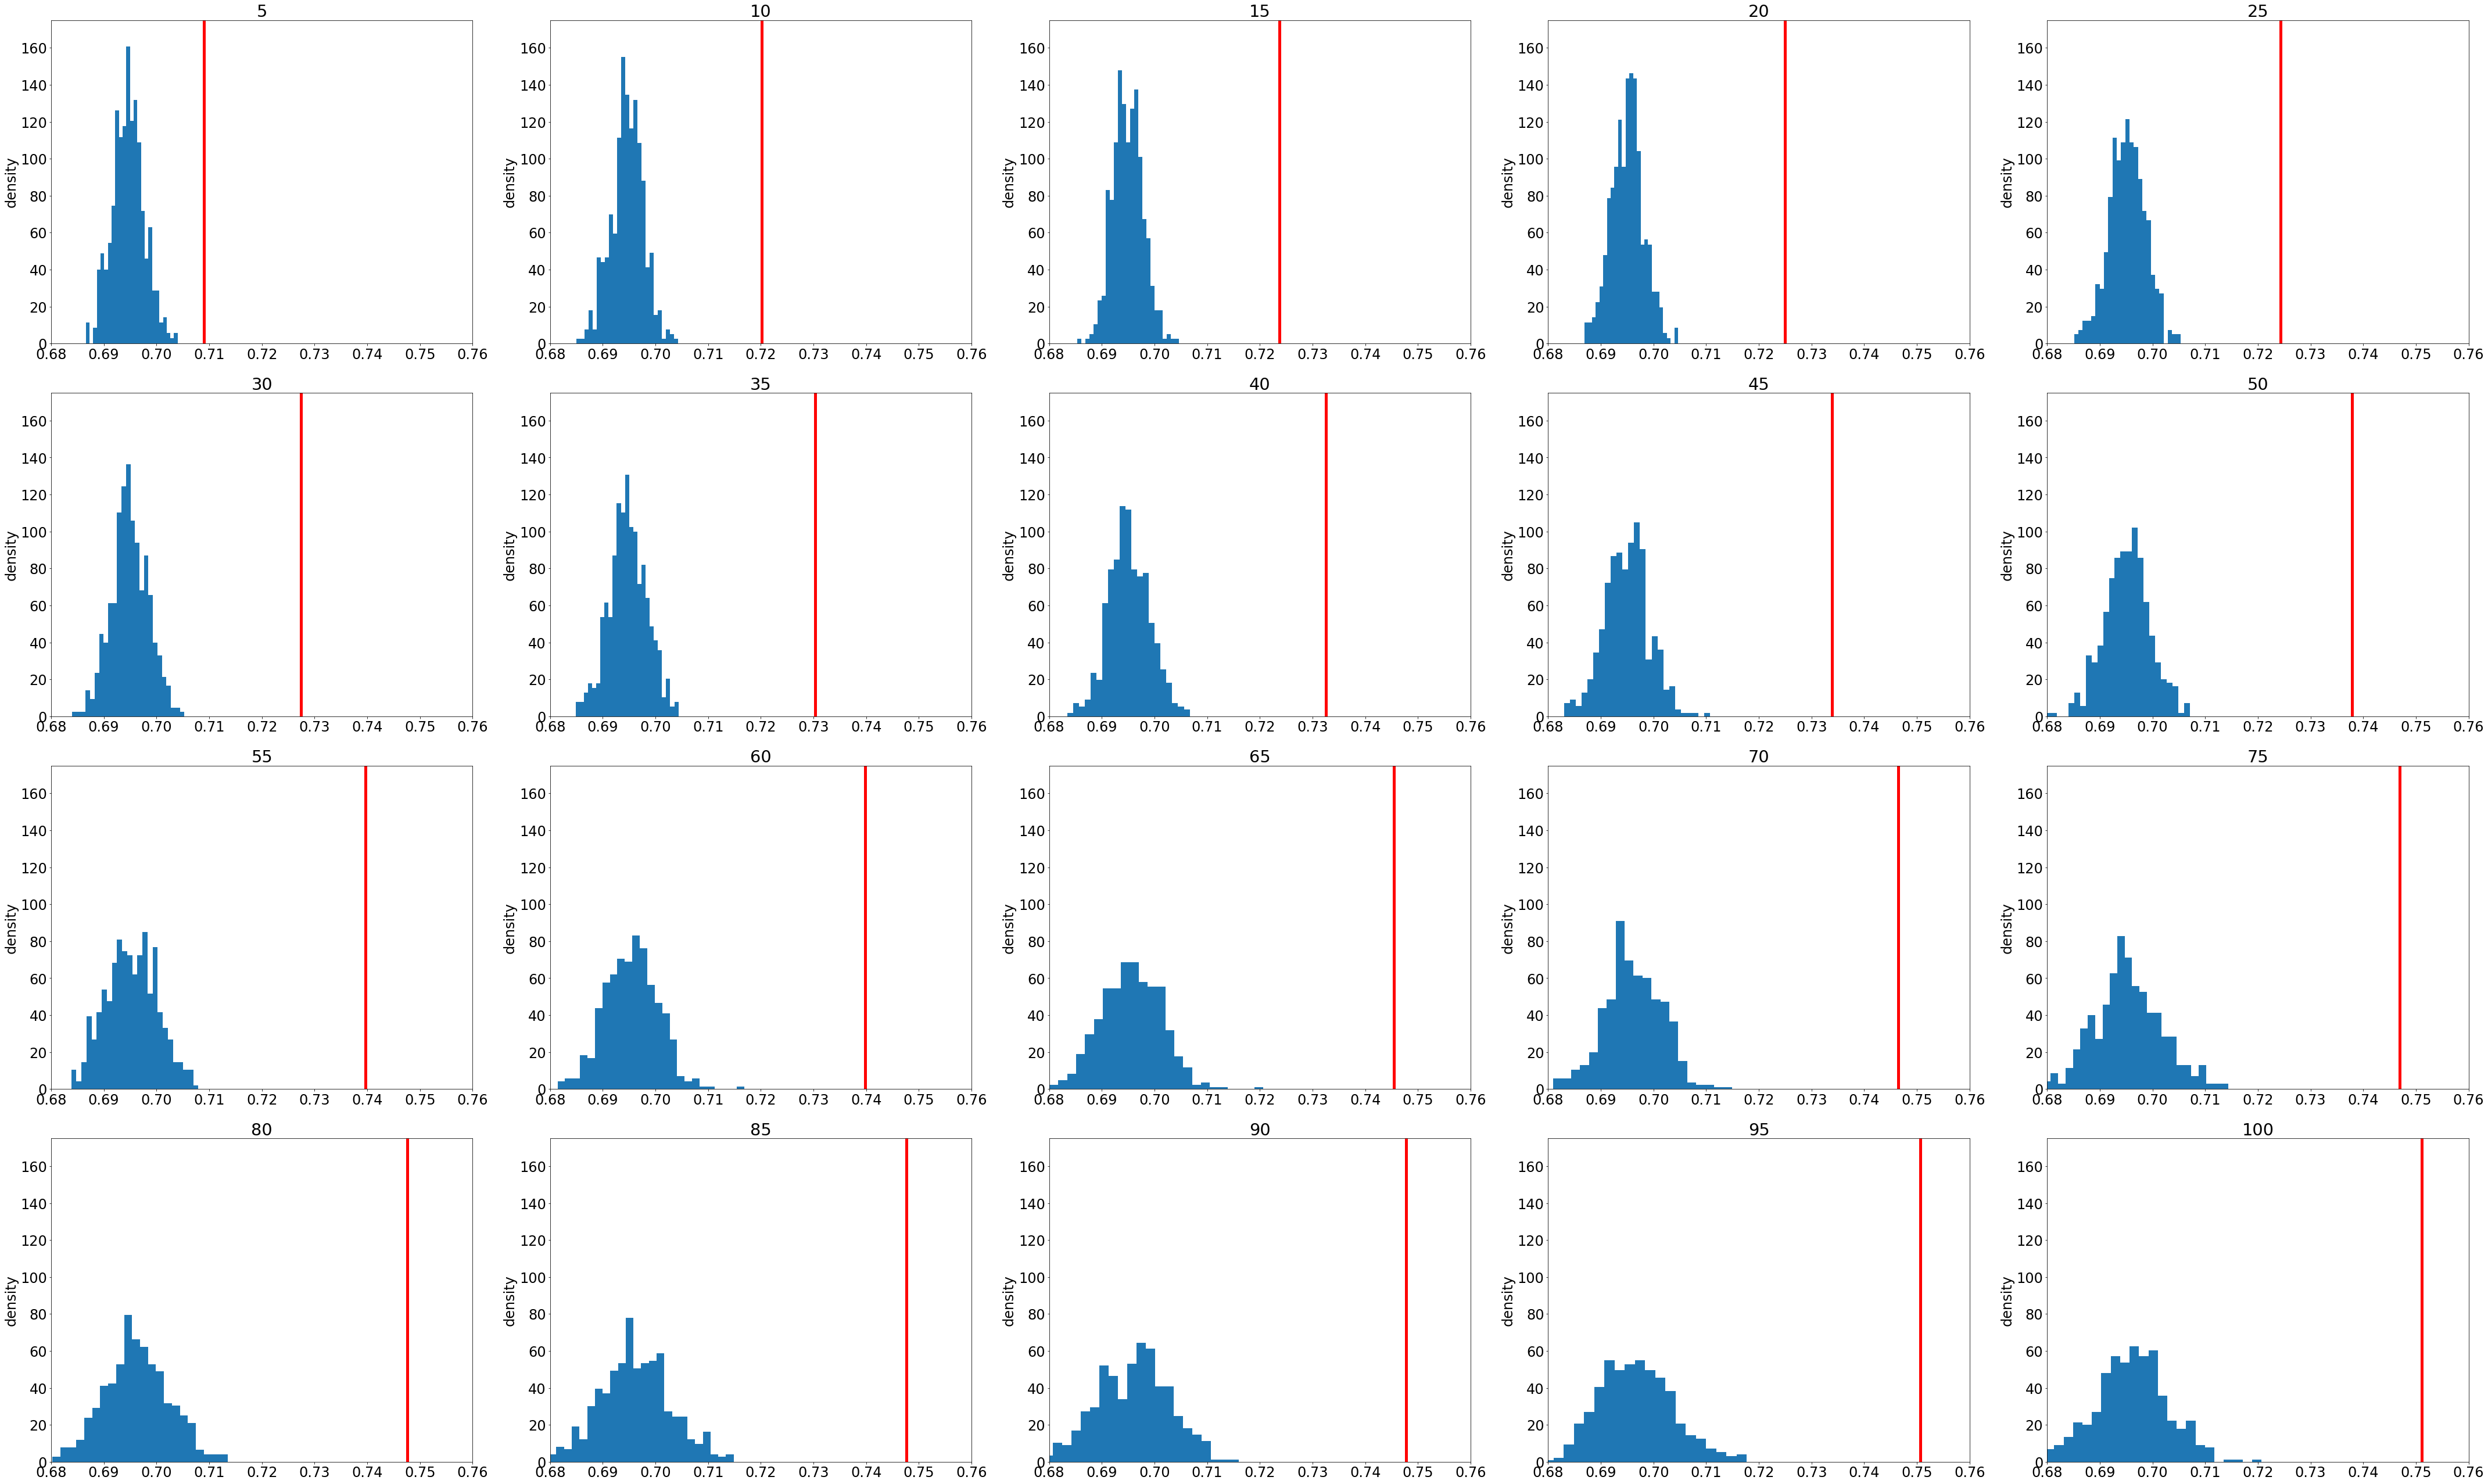

In [30]:
bins = 25
THR = 510000
ncols = 5
nrows = 4
plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 12, nrows * 9))
for i in range(nrows):
    for j in tqdm(range(ncols)):
        index = 5 * (ncols * i + j + 1)
        fractions_of_good_boundaries = [(np.array(A[:, 0]) < THR).mean() 
                                for A in mistakes_generated[index]]
        ax[i][j].hist(
            fractions_of_good_boundaries,
            bins=bins, density=True)
        ax[i][j].set_title(f"{index}")
        ax[i][j].vlines((np.array(mistakes[index])[:, 0] < THR).mean(), 0, 200, color="red", linewidth=5)
        ax[i][j].set_xlim(.68, .76)
        ax[i][j].set_ylim(0, 175)
        ax[i][j].set_ylabel("density")
        ax[i][j].set_xlabel("fraction of good boundaries")
plt.tight_layout()        
plt.show()
# plt.savefig("p-values.jpg", dpi=200)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.00it/s]


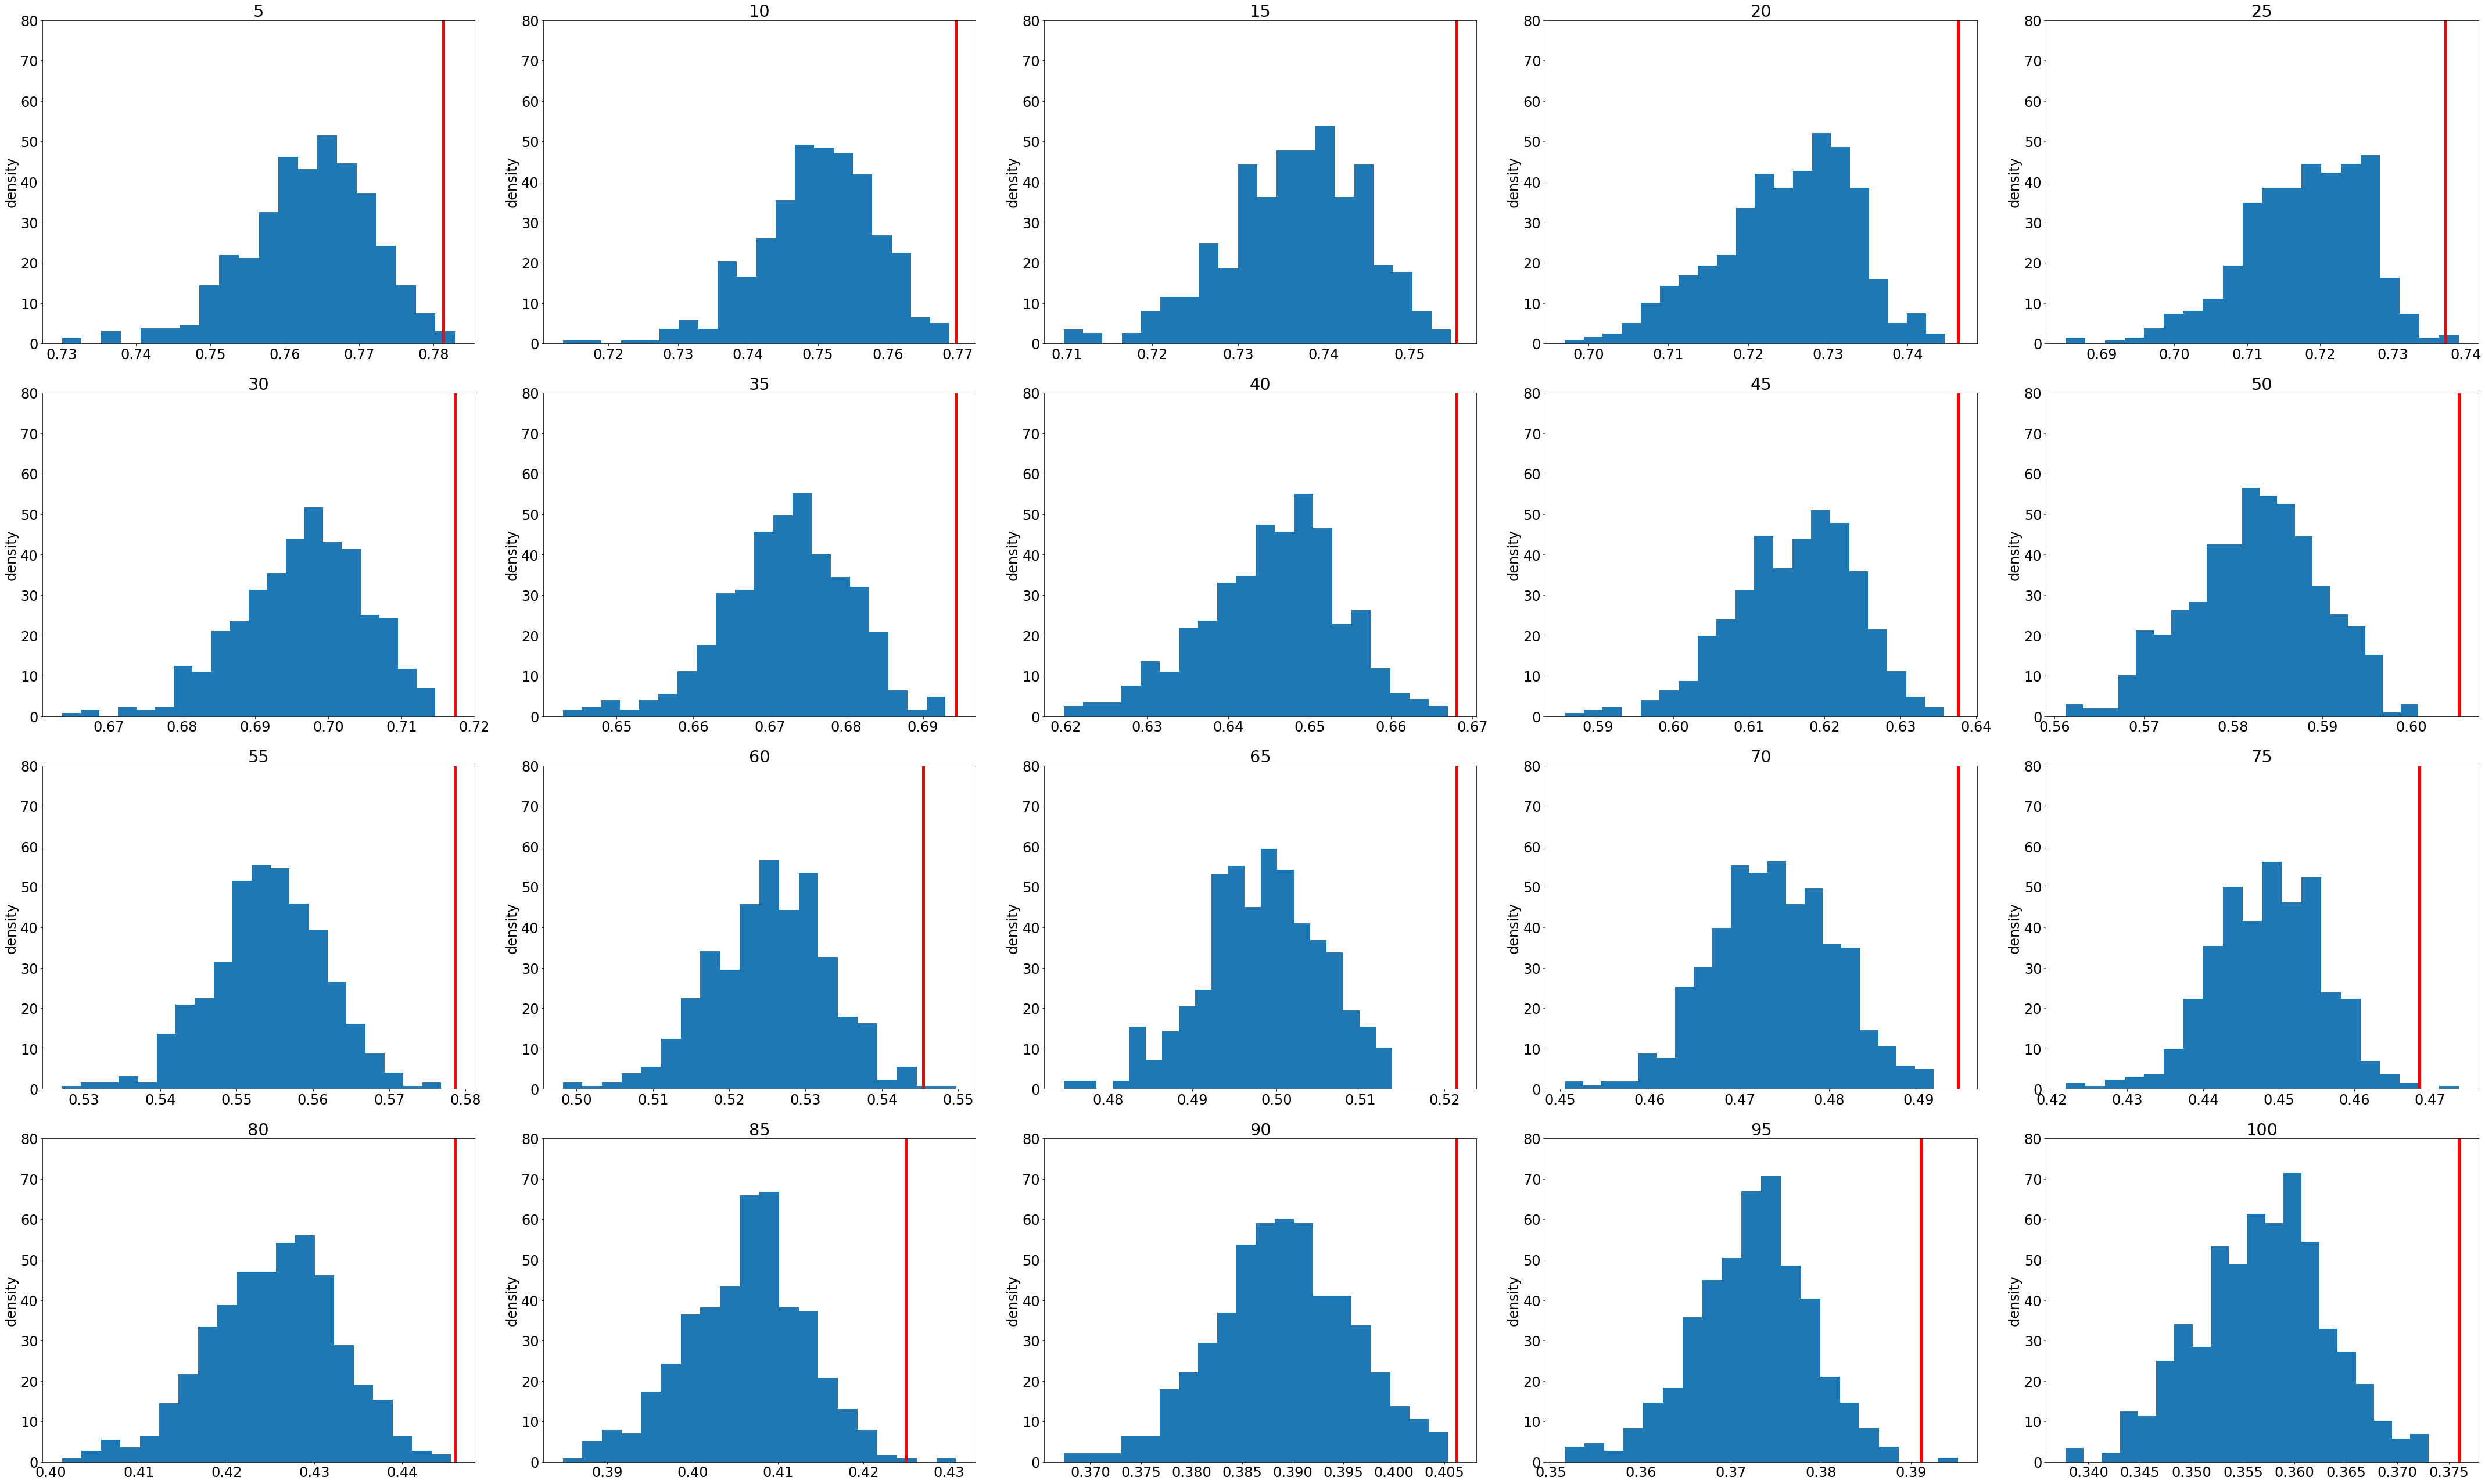

In [29]:
bins = 20
THR = 510000
ncols = 5
nrows = 4
plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 12, nrows * 9))
for i in range(nrows):
    for j in tqdm(range(ncols)):
        index = 5 * (ncols * i + j + 1)
        
        fractions_of_predicted_tads = [
            np.unique(np.array(A)[:, 1][np.array(A)[:, 0] < THR]).shape[0] / num_tads 
            for A in mistakes_generated[index]
        ]
        
        ax[i][j].hist(
            fractions_of_predicted_tads,
            bins=bins,
            density=True
        )
        
        ax[i][j].set_title(f"{index}")
        ax[i][j].vlines(
            np.unique(np.array(mistakes[index])[:, 1][np.array(mistakes[index])[:, 0] < THR]).shape[0] / num_tads,
            0,
            200,
            color="red",
            linewidth=5
        )
#         ax[i][j].set_xlim(.5, 1)
        ax[i][j].set_ylim(0, 80)
        ax[i][j].set_ylabel("density")
        ax[i][j].set_xlabel("")

plt.tight_layout()
plt.show()
# plt.savefig("predicted_tads.jpg", dpi=200)